In [2]:
import cv2
import numpy as np
import pandas as pd
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

TRAIN_DIR = '/home/chiru/Desktop/Fynd/images/Train Directory/'
TEST_DIR = '/home/chiru/Desktop/Fynd/images/Test Directory/'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'clothes-classification-{}-{}.model'.format(LR,'2conv-basic')

labels=['Abstract','Checked','ColourBlock',
           'Floral','Graphic','Melange',
           'Patterned','Polka Dots','Printed',
           'Solid','Striped','Typography']

In [3]:
def label_img(folder):
    word_label=folder
    if word_label == 'abstract': return [1,0,0,0,0,0,0,0,0,0,0,0]
    elif word_label == 'Checked': return [0,1,0,0,0,0,0,0,0,0,0,0]
    elif word_label == 'Colourblock': return [0,0,1,0,0,0,0,0,0,0,0,0]
    elif word_label == 'floral': return [0,0,0,1,0,0,0,0,0,0,0,0]
    elif word_label == 'graphic': return [0,0,0,0,1,0,0,0,0,0,0,0]
    elif word_label == 'Melange': return [0,0,0,0,0,1,0,0,0,0,0,0]
    elif word_label == 'Patterned': return [0,0,0,0,0,0,1,0,0,0,0,0]
    elif word_label == 'polka dots': return [0,0,0,0,0,0,0,1,0,0,0,0]
    elif word_label == 'Printed': return [0,0,0,0,0,0,0,0,1,0,0,0]
    elif word_label == 'solid': return [0,0,0,0,0,0,0,0,0,1,0,0]
    elif word_label == 'striped': return [0,0,0,0,0,0,0,0,0,0,1,0]
    elif word_label == 'typography': return [0,0,0,0,0,0,0,0,0,0,0,1]

In [4]:
def create_train_data():
    training_data=[]
    for folder in tqdm(os.listdir(TRAIN_DIR)):
        for img in os.listdir(os.path.join(TRAIN_DIR,folder)):
            label=label_img(folder)
            path=os.path.join(TRAIN_DIR,folder,img)
            img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
            training_data.append([np.array(img),np.array(label)])

    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data


In [5]:
def process_test_data():
    test_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num=img.split('.')[0]
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        test_data.append([np.array(img),img_num])
        
    np.save('test_data.npy',test_data)
    return test_data 

In [6]:
#train_data=create_train_data()
train_data=np.load('train_data.npy')

In [7]:
len(train_data)

3370

In [8]:
train = train_data[:-370]
test = train_data[-370:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [9]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 12, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log',tensorboard_verbose=2)



#if os.path.exists('{}.meta'.format(MODEL_NAME)):
#    model.load(MODEL_NAME)
 #   print('model loaded!')

model.fit({'input': X}, {'targets': Y}, n_epoch=50, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=50000, show_metric=True, run_id=MODEL_NAME)


Training Step: 2349  | total loss: 0.46327 | time: 24.413s
| Adam | epoch: 050 | loss: 0.46327 - acc: 0.8319 -- iter: 2944/3000
Training Step: 2350  | total loss: 0.47522 | time: 25.578s
| Adam | epoch: 050 | loss: 0.47522 - acc: 0.8222 | val_loss: 3.24072 - val_acc: 0.3946 -- iter: 3000/3000
--


In [10]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/chiru/Desktop/Python_Projects/clothes-classification-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 67/67 [00:00<00:00, 264.87it/s]


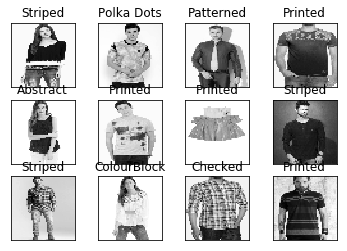

In [21]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[20:32]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    #print np.argmax(model_out)
   # print model_out
    str_label=labels[np.argmax(model_out)]
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [13]:
with open('clothes_submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('colothes_submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        str_label=labels[np.argmax(model_out)]
        f.write('{},{}\n'.format(img_num,str_label))

100%|██████████| 67/67 [00:00<00:00, 414.64it/s]
